In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

from energymodel import (
    EnergyModel, EMSolver, random_uniform, NanMonitor, Lyapunov
)

tf.compat.v1.reset_default_graph()

## Dataset

In [2]:
def remap(x):
    """Re-map the x to the range [-1, 1]."""
    x = tf.where(x < -1, -x - 2, x)
    x = tf.where(x > 1, -x + 2, x)
    return x

def vector_field(z):
    """This vector field is provided by Ian Stewart, in his paper:
    Symmetry-Breaking as an Origin of Species, example 1.

        dx/dt =  λ x + 2 x^2 - x^3
        dλ/dt = 0

    and z := (x, λ). The λ is bounded in (-1.5, 0.5).
    """
    # The x and the lambda
    x, l = tf.unstack(z, axis=1)

    # Re-map lambda to (-1.5, 0.5)
    l = -0.5 - remap(l + 0.5)

    dx = l * x + 2 * x**2 - x**3
    dl = tf.zeros_like(l)

    return tf.stack([dx, dl], axis=1)

def resample(batch_size):
    # x in (-1, 3)
    x = 1 + 2 * random_uniform([batch_size])
    # l in (-1.5, 0.5)
    l = -0.5 + random_uniform([batch_size])
    return tf.stack([x, l], axis=1)


batch_size = 128
solver = EMSolver(dt=1e-1, eps=1e-2)

lyapunov = Lyapunov(
    vector_field,
    resample,
    solver,
    5e-0,
    1e-2,
)

## Model

In [3]:
network = models.Sequential([
    layers.Dense(256),
    layers.Activation('swish'),

    layers.Dense(64),
    layers.Activation('swish'),

    layers.Dense(1, use_bias=False),
])
network(resample(batch_size))  # build.

model = EnergyModel(
    network,
    resample,
    solver,
    5e-0,
)
tf.print('T =', model.T)

optimizer = tf.keras.optimizers.Adam(1e-3, clipvalue=1e-1)
callbacks = [
    NanMonitor(5),
]

train_step = model.get_optimize_fn(optimizer, callbacks)
train_step = tf.function(train_step)

T = 0.0337821916


In [4]:
for step in tqdm(range(5000)):
    batch = lyapunov(batch_size)
    train_step(batch)

100%|██████████| 5000/5000 [06:08<00:00, 13.57it/s]


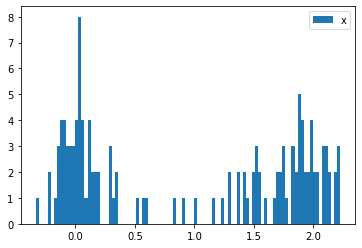

In [5]:
plt.hist(lyapunov(batch_size).numpy()[:, 0], bins=100, label='x')
plt.legend()
plt.show()

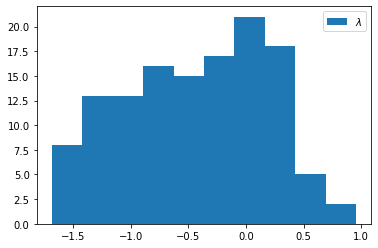

In [6]:
plt.hist(lyapunov(batch_size).numpy()[:, 1], label='$\lambda$')
plt.legend()
plt.show()

## Evaluation

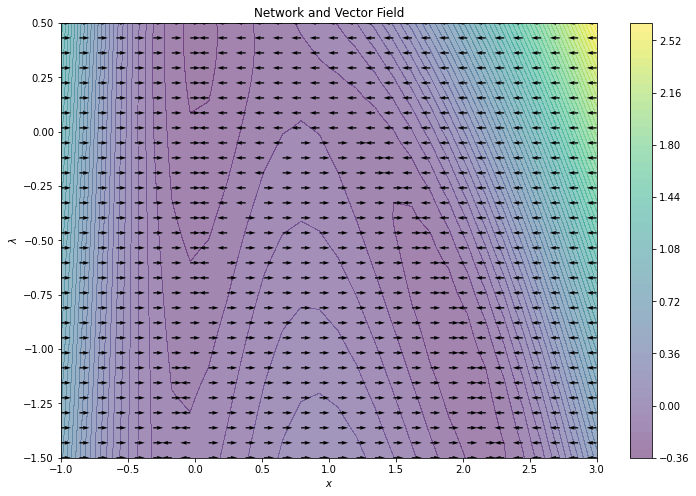

In [7]:
fig = plt.figure(figsize=(12, 8))
               
num_grids = 30
plot_X, plot_Y = np.meshgrid(
    np.linspace(-1, 3, num_grids),
    np.linspace(-1.5, 0.5, num_grids),
)
plot_batch = np.stack(
    [plot_X.reshape([-1]), plot_Y.reshape([-1])],
    axis=1
)
E = -network(plot_batch).numpy().reshape(num_grids, num_grids)
plt.contourf(plot_X, plot_Y, E, 50, alpha=0.5)
plt.colorbar()

vec = vector_field(plot_batch).numpy().reshape(num_grids, num_grids, 2)
vec = np.sign(vec)
vec_X, vec_Y = vec[:, :, 0], vec[:, :, 1]
plt.quiver(plot_X, plot_Y, vec_X, vec_Y)

plt.xlabel('$x$')
plt.ylabel('$\lambda$')

plt.title('Network and Vector Field')
plt.show()

In [8]:
def dot(x, y):
    return tf.reduce_sum(x * y, axis=1)

def criterion(test_batch):
    return dot(model.vector_field(test_batch), vector_field(test_batch))

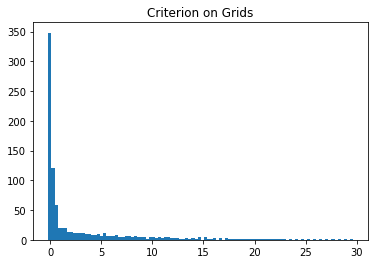

Minimum = -0.18907679268444413


In [9]:
plot_criterion = criterion(tf.convert_to_tensor(plot_batch))
plot_criterion = plot_criterion.numpy().reshape([num_grids, num_grids])

plt.hist(plot_criterion.reshape([-1]), bins=100)
plt.title('Criterion on Grids')
plt.show()

print('Minimum =', plot_criterion.min())

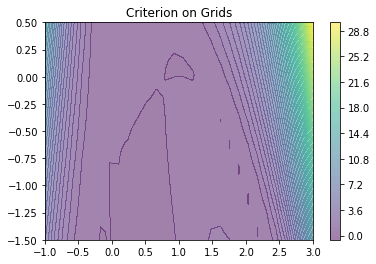

In [10]:
plt.contourf(plot_X, plot_Y, plot_criterion, 50, alpha=0.5)
plt.colorbar()
plt.title('Criterion on Grids')
plt.show()

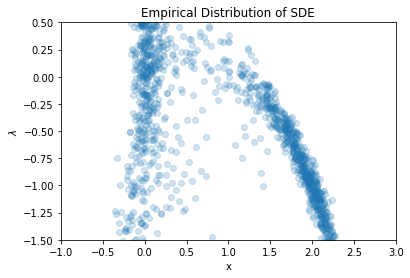

In [20]:
plot_lyapunov = lyapunov(batch_size * 10).numpy()
plt.scatter(plot_lyapunov[:, 0], plot_lyapunov[:, 1], alpha=0.2)
plt.xlim(-1, 3)
plt.ylim(-1.5, 0.5)
plt.xlabel('x')
plt.ylabel('$\lambda$')
plt.title('Empirical Distribution of SDE')
plt.show()